### SCRAPING

In [ ]:
# Reddit mining using PRAW
import praw

reddit = praw.Reddit(
  client_id='6NE27-qV7tGX07FuBfik3w',
  client_secret='fauqCWKne1OXmmtzPIABkNW57DFyZA',
  user_agent='Comment scraper'
)

In [ ]:
import json
import re
import html
from langdetect import detect, LangDetectException

subreddit_names = ['Anxiety', 'mentalhealth']
posts_data = []
total_comments = 0
target_comments = 5000
mod_keywords = ['announcement', 'rules', 'mod', 'moderator', 'admin', 'clarification', 'faq', 'meta', 'update', 'policy']

def is_mod_post(post):
  if post.distinguished in ['moderator', 'admin']:
    return True
  text = (post.title + " " + post.selftext).lower()
  return any(keyword in text for keyword in mod_keywords)

def is_mod_comment(comment):
  if comment.distinguished in ['moderator', 'admin']:
    return True
  text = comment.body.lower()
  return any(keyword in text for keyword in mod_keywords)

def clean_text(text):
  if not text:
    return ""
  text = html.unescape(text)                                                  # Decode HTML entities
  text = re.sub(r'\[deleted\]|[removed]', '', text, flags = re.IGNORECASE)    # remove [deleted]/[removed]
  text = re.sub(r'httpS+|wwwS+', '', text)                                    # Remove URLs
  text = re.sub(r'&w+;', '', text)                                            # Remove encoded HTML symbols
  text = re.sub(r'u/w+|r/w+', '', text)                                       # Remove mentions
  text = re.sub(r'>.*n?', '', text)                                           # Remove blockquotes
  text = re.sub(r'*+', '', text)                                              # Remove markdown asterisks
  text = re.sub(r'[rn\t]', ' ', text)                                         # Normalize whitespace
  text = re.sub(r'[^a-zA-Z\s\.,!?\'":;()\[\]{}\-]', '', text)                 # Remove numbers, unicode, & symbols
  text = re.sub(r'[^\x00-\x7F]+', '', text)                                   # Remove non-ASCII characters
  text = re.sub(r'\s+([.,!?;:])', r'\1', text)                                # Remove spaces before punctuation
  text = re.sub(r'([!?])\1{2,}', r'\1\1\1', text)                             # Limit repeated punctuation to max 3
  text = re.sub(r'(\.\s*){2,}', '...', text)                                  # Normalize ellipses
  text = re.sub(r'\.{4,}', '...', text)                                       # Normalize ellipses
  text = re.sub(r'\s{2,}', ' ', text)                                         # Collapse multiple spaces
  return text.strip().lower()

def is_english(text):
  try:
    if len(text) < 20:
      return False
    return detect(text) == 'en'
  except LangDetectException:
    return False

for sub_name in subreddit_names:
  sub_comments = 0
  
  for submission in reddit.subreddit(sub_name).new(limit = None):
    if sub_comments >= target_comments / len(subreddit_names):
      break

    if is_mod_post(submission):
      continue

    submission.comments.replace_more(limit = 0)
    comments = []

    for comment in submission.comments.list():
      if is_mod_comment(comment):
        continue

      clean_body = clean_text(comment.body)

      if not is_english(clean_body):
        continue

      comments.append({
        'comment_id': comment.id,
        'body': clean_body,
        'author': comment.author.name if comment.author else "[deleted]",
        'author_role': comment.distinguished,
        'score': comment.score,
        'created_utc': comment.created_utc,
        'is_submitter': comment.is_submitter,
        'parent_id': comment.parent_id,
        'permalink': comment.permalink
      })

    if comments:
      sub_comments += len(comments)
      total_comments += len(comments)

      post = {
        'post_id': submission.id,
        'title': clean_text(submission.title),
        'selftext': clean_text(submission.selftext),
        'author': submission.author.name if submission.author else "[deleted]",
        'author_role': submission.distinguished,
        'score': submission.score,
        'upvote_ratio': submission.upvote_ratio,
        # 'url': submission.url,
        'created_utc': submission.created_utc,
        'num_comments': len(comments),
        'subreddit': submission.subreddit.display_name,
        'flair': submission.link_flair_text,
        'is_self': submission.is_self,
        'nsfw': submission.over_18,
        'permalink': submission.permalink,
        'comments': comments
      }
      posts_data.append(post)

  print(f"{sub_comments} comments collected from r/{sub_name}")

with open('raw_posts.json', 'w', encoding='utf-8') as f:
  json.dump(posts_data, f, indent = 2, ensure_ascii=False)

print(f"\nScraped {len(posts_data)} posts with {total_comments} comments.")

### DATA CLEANING

In [ ]:
import json

with open('raw_posts.json', 'r', encoding='utf-8') as f:
  raw_data = json.load(f)

In [ ]:
from datetime import datetime, timezone

cleaned_data = []
total_cleaned_posts = 0
total_cleaned_comments = 0
mod_keywords = ['announcement', 'rules', 'mod', 'moderator', 'admin', 'clarification', 'faq', 'meta', 'update', 'policy']

def format_datetime(utc_timestamp):
  return datetime.fromtimestamp(utc_timestamp, tz=timezone.utc).isoformat()

def is_meaningful(text):
  if len(text) < 20:                      # Remove short comments
    return False
  if not any(c.isalpha() for c in text):  # Must contain alphabetic characters
    return False
  if len(text) > 2000:                    # remove very long comments 
    return False
  return True

for post in raw_data:
  cleaned_post = {
    'post_id': post['post_id'],
    'title': post['title'],
    'selftext': post['selftext'],
    'author': post['author'],
    'author_role': post['author_role'],
    'score': post['score'],
    'upvote_ratio': post['upvote_ratio'],
    'created_utc': format_datetime(post['created_utc']),
    'num_comments': 0,
    'subreddit': post['subreddit'],
    'flair': post['flair'],
    'is_self': post['is_self'],
    'nsfw': post['nsfw'],
    'permalink': post['permalink'],
    'comments': []
  }

  for comment in post['comments']:
    if comment['body'] == "":
      continue
    if comment['author'] == "[deleted]":
      continue
    if not is_meaningful(comment['body']):
      continue

    cleaned_comment = {
      'comment_id': comment['comment_id'],
      'body': comment['body'],
      'author': comment['author'],
      'author_role': comment['author_role'],
      'score': comment['score'],
      'created_utc': format_datetime(comment['created_utc']),
      'is_submitter': comment['is_submitter'],
      'parent_id': comment['parent_id'],
      'permalink': comment['permalink']
    }
    cleaned_post['comments'].append(cleaned_comment)

  if cleaned_post['comments']:
    cleaned_post['num_comments'] = len(cleaned_post['comments'])
    total_cleaned_posts += 1
    total_cleaned_comments += len(cleaned_post['comments'])
    cleaned_data.append(cleaned_post)

with open('cleaned_posts.json', 'w', encoding='utf-8') as f:
  json.dump(cleaned_data, f, indent = 2, ensure_ascii = False)

print(f"Data cleaned. {total_cleaned_posts} posts remaining with {total_cleaned_comments} comments.")

### SQL LOADING

In [ ]:
import psycopg2
import json

conn = psycopg2.connect(
  host = "127.0.0.1",
  user = "postgres",
  password = "SqlPassword",
  dbname = "reddit_data",
  port = "5432"
)
cur = conn.cursor()

with open('cleaned_posts.json', 'r', encoding = 'utf-8') as f:
  data = json.load(f)

In [ ]:
from datetime import datetime

flair_category = {
  "Venting": "Depression",
  "Sadness / Grief": "Depression",
  "Content Warning: Suicidal Thoughts / Self Harm": "Depression",
  "Content Warning: Eating Disorders": "Depression",
  "Content Warning: Sexual Assault": "Depression",
  "Content Warning: Violence": "Depression",
  "Content Warning: Addiction / Substance Abuse": "Depression",
  "Trigger Warning": "Depression",
  "Diary Entry": "Depression",
  "Poetry": "Depression",

  "Anxiety Resource": "Anxiety",
  "Driving": "Anxiety",
  "Work/School": "Anxiety",
  "Travel": "Anxiety",
  "Sleep": "Anxiety",
  "Lifestyle": "Anxiety",
  "Health": "Anxiety",
  "Family/Relationship": "Anxiety",
  "Question": "Anxiety",
  "DAE Questions": "Anxiety",
  "Opinion / Thoughts": "Anxiety",

  "Advice Needed": "Therapy",
  "Need Support": "Therapy",
  "Needs A Hug/Support": "Therapy",
  "Therapy": "Therapy",
  "Medication": "Therapy",
  "Help A Loved One": "Therapy",
  "Helpful Tips!": "Therapy",
  "Resources": "Therapy",
  "Research Study": "Therapy",
  "Inspiration / Encouragement": "Therapy",
  "Good News / Happy": "Therapy",
  "Share Your Victories": "Therapy",
  "Uplifting": "Therapy",
  "Progress!": "Therapy",
  "Discussion": "Therapy",
  "Introduction": "Therapy",
}

def unique_topic(flair):
  cur.execute("""
    INSERT INTO dim_topic (topic_label, flair)
    VALUES (%s, %s)
    ON CONFLICT (flair) DO NOTHING
    RETURNING topic_id;
  """, (flair_category.get(flair, "Other"), flair))
  result = cur.fetchone()
  if not result:
    cur.execute("SELECT topic_id FROM dim_topic WHERE flair = %s;", (flair,))
    result = cur.fetchone()
  return result[0]

def unique_date_id(dt):
  cur.execute("""
    INSERT INTO dim_date (full_date, year, quarter, month, day, weekday)
    VALUES (%s, %s, %s, %s, %s, %s)
    ON CONFLICT (full_date) DO NOTHING
    RETURNING date_id;
  """, (dt.date(), dt.year, ((dt.month - 1) // 3 + 1), dt.month, dt.day, dt.strftime('%A')))
  result = cur.fetchone()
  if not result:
    cur.execute("SELECT date_id FROM dim_date WHERE full_date = %s;", (dt.date(),))
    result = cur.fetchone()
  return result[0]

for post in data:
  cur.execute("""
    INSERT INTO dim_posts (post_id, title, selftext, author, author_role, score, upvote_ratio, created_utc, num_comments, subreddit, is_self, nsfw, permalink)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    """, (post['post_id'], post['title'], post['selftext'], post['author'], post['author_role'], post['score'], post['upvote_ratio'], post['created_utc'], post['num_comments'], post['subreddit'], post['is_self'], post['nsfw'], post['permalink'])
  )

  topic_id = unique_topic(post['flair'])

  for comment in post['comments']:
    cur.execute("""
      INSERT INTO dim_comment (comment_id, author, author_role, body, score, created_utc, is_submitter, parent_id, permalink)
      VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
      """, (comment['comment_id'], comment['author'], comment['author_role'], comment['body'], comment['score'], comment['created_utc'], comment['is_submitter'], comment['parent_id'], comment['permalink'])
    )

    dt = datetime.fromisoformat(comment['created_utc'])
    date_id = unique_date_id(dt)

    cur.execute("""
      INSERT INTO fact_table (comment_id, post_id, topic_id, date_id, is_submitter, comment_score, comment_length)
      VALUES (%s, %s, %s, %s, %s, %s, %s);
      """, (comment['comment_id'], post['post_id'], topic_id, date_id, comment['is_submitter'], comment['score'], len(comment['body']))
    )

conn.commit()
cur.close()
conn.close()

### TOPIC MODELING

In [ ]:
import psycopg2
import pandas as pd
import spacy
from bertopic import BERTopic

conn = psycopg2.connect(
  host = "127.0.0.1",
  user = "postgres",
  password = "SqlPassword",
  dbname = "reddit_data",
  port = "5432"
)
cur = conn.cursor()

# Load comments
dfTopic = pd.read_sql_query("SELECT comment_id, body FROM dim_comment;", conn)

conn.commit()
cur.close()
conn.close()

# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
# vague nouns
exclude_words = {"thing", "day", "time", "know", "get", "say", "fly", "way", "lot", "real", "able", "hour", "people", "person", "life", "year"}

# Lemmatize and clean
def lemmatize(text):
  doc = nlp(text)
  return " ".join([
    token.lemma_ for token in doc
    if not token.is_stop
    and token.is_alpha                              # remove punctuation/numbers
    and token.pos_ in {"NOUN", "ADJ", "VERB"}       # only useful words
    and len(token.lemma_) > 2                       # ignore 1-2 letter words
    and token.lemma_.lower() not in exclude_words
  ])

# preprocessing
dfTopic["cleaned_body"] = dfTopic["body"].astype(str).apply(lemmatize)
documents = dfTopic["cleaned_body"].tolist()

# Seed list helps guide the model
seed_topics_list = [
  ["anxiety", "panic", "attack", "worry", "overwhelm", "nervous", "overthink", "fear", "restless", "sweat", "tremble", "rush", "heart", "fast", "trigger", "phobia", "chest", "tight", "breathe"],
  ["depression", "sad", "sadness", "hopeless", "suicide", "worthless", "fatigue", "empty", "cry", "sleep", "numb", "tired", "low", "dark", "alone", "disappear", "fail", "useless", "blame", "quiet"],
  ["therapy", "talk", "counselor", "counseling", "cbt", "session", "support", "appointment", "therapist", "diagnose", "treatment", "professional", "cope", "relate", "progress", "discuss", "help", "listen", "recover", "resource"]
]

# Fit model
topic_model = BERTopic(
  language="english",
  nr_topics=3,
  seed_topic_list=seed_topics_list,
  calculate_probabilities=True,
  verbose=True
)
topics, probs = topic_model.fit_transform(documents)
# Inspect topic keywords
topic_info = topic_model.get_topic_info()
print(topic_info)

for i in range(3):
  print(f"\nTopic {i}:")
  print(topic_model.get_topic(i - 1))

dfTopic["topic_id"] = topics

In [ ]:
import psycopg2

conn = psycopg2.connect(
  host = "127.0.0.1",
  user = "postgres",
  password = "SqlPassword",
  dbname = "reddit_data",
  port = "5432"
)
cur = conn.cursor()

for _, row in dfTopic.iterrows():
  cur.execute("""
    UPDATE fact_table SET topic_classification = %s WHERE comment_id = %s;
    """, (row['topic_id'] + 1, row['comment_id'])
  )

conn.commit()
cur.close()
conn.close()

### EXTRACTING KEYWORDS PER FLAIR

In [ ]:
import psycopg2
import pandas as pd
import spacy
from collections import Counter

conn = psycopg2.connect(
  host = "127.0.0.1",
  user = "postgres",
  password = "SqlPassword",
  dbname = "reddit_data",
  port = "5432"
)
cur = conn.cursor()

# Load flairs with comments
dfFlair = pd.read_sql_query("SELECT ft.comment_id, t.flair, c.body FROM fact_table ft JOIN dim_topic t ON ft.topic_id = t.topic_id JOIN dim_comment c ON ft.comment_id = c.comment_id GROUP BY ft.comment_id, t.flair, c.body;", conn)

conn.commit()
cur.close()
conn.close()

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
# Vague words
exclude_words = {"thing", "day", "time", "know", "get", "say", "fly", "way", "lot", "real", "able", "hour", "people", "person", "life", "year"}

def lemmatize(text):
  doc = nlp(text)
  return [
    token.lemma_ for token in doc
    if not token.is_stop
    and token.is_alpha
    and token.pos_ in {"NOUN", "ADJ", "VERB"}
    and len(token.lemma_) > 2
    and token.lemma_.lower() not in exclude_words
  ]

top_keywords_per_flair = {}

for flair in dfFlair["flair"].unique():
  flair_comments = dfFlair[dfFlair["flair"] == flair]["body"]
  all_lemmas = []
  for comment in flair_comments:
    all_lemmas.extend(lemmatize(comment))
  top_keywords = Counter(all_lemmas).most_common(10)    # Get top 10 words
  top_keywords_per_flair[flair] = top_keywords

In [ ]:
import psycopg2

top_keywords_per_flair_str = {
  flair: ", ".join([word for word, _ in keywords])
  for flair, keywords in top_keywords_per_flair.items()
}

conn = psycopg2.connect(
  host="127.0.0.1",
  user="postgres",
  password="SqlPassword",
  dbname="reddit_data",
  port="5432"
)
cur = conn.cursor()

for topic_label, keyword_str in top_keywords_per_flair_str.items():
  cur.execute(
    "UPDATE dim_topic SET keywords = %s WHERE flair = %s;",
    (keyword_str, topic_label)
  )

conn.commit()
cur.close()
conn.close()

### PLOTING

In [60]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Connect to the database
conn = psycopg2.connect(
  host="127.0.0.1",
  user="postgres",
  password="SqlPassword",
  dbname="reddit_data",
  port="5432"
)
cur = conn.cursor()

# Query topic_label and keywords
df_keywords = pd.read_sql_query("SELECT topic_label, keywords FROM dim_topic;", conn)

conn.commit()
cur.close()
conn.close()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13252\2259678955.py:18: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [61]:
import pandas as pd
from collections import Counter

# Explode the comma-separated keywords into rows
rows = []
for _, row in df_keywords.iterrows():
  topic = row['topic_label']
  keywords = [kw.strip() for kw in row['keywords'].split(',')]
  rows.extend([(topic, kw) for kw in keywords])

df_keywords = pd.DataFrame(rows, columns=["Topic", "Keyword"])
df_keyword_counts = df_keywords.value_counts(["Topic", "Keyword"]).reset_index(name="Count")

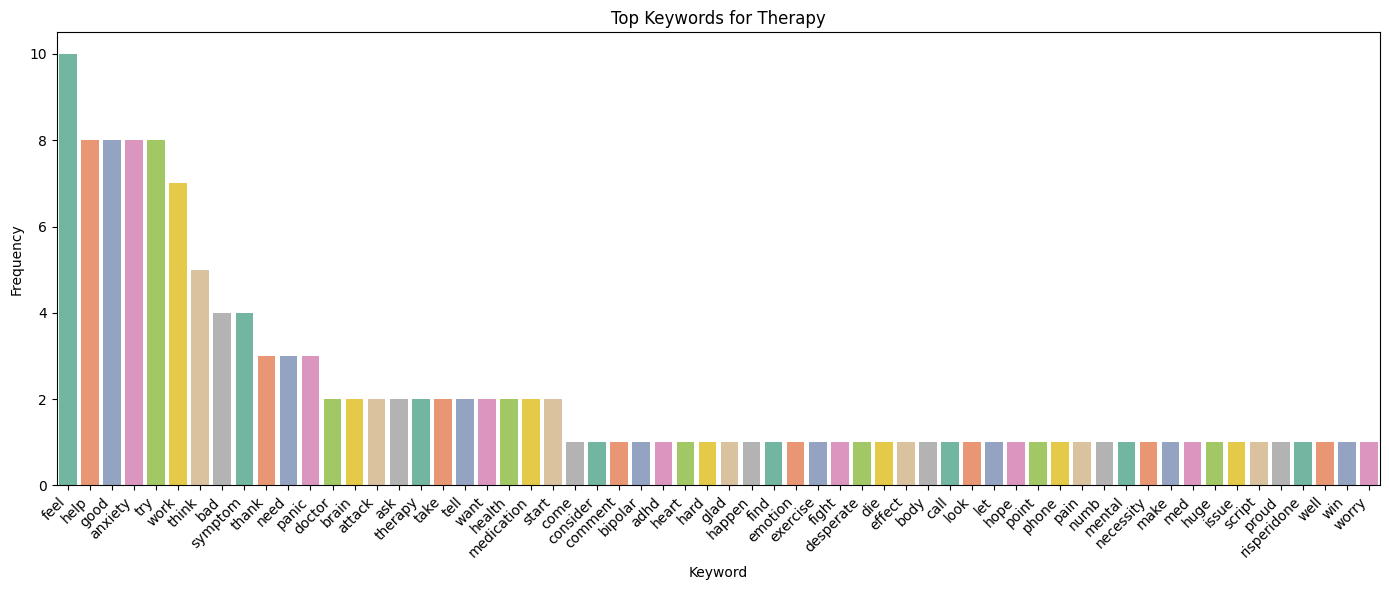

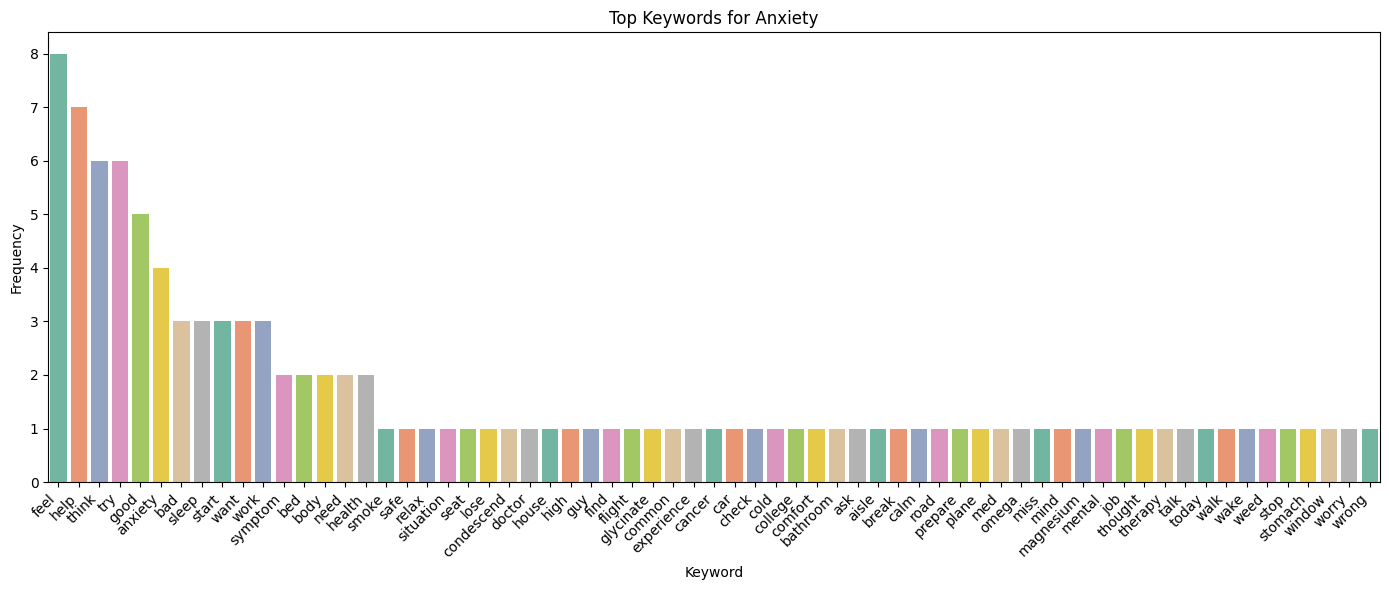

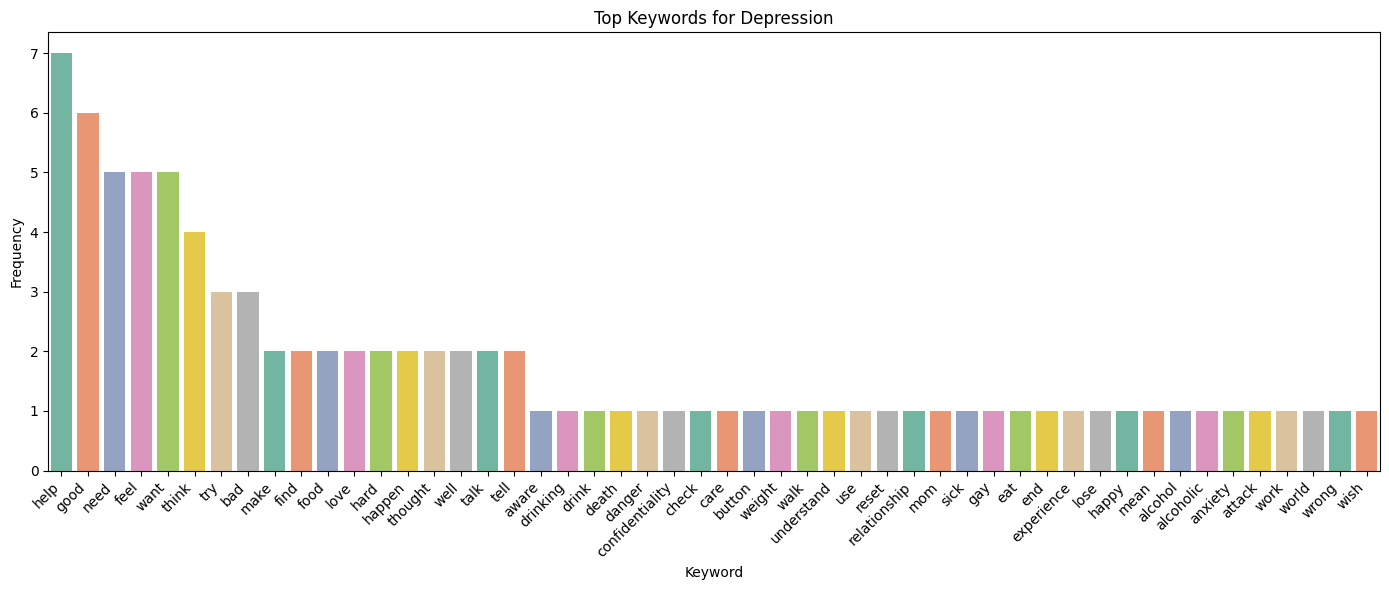

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar Plot
for topic in df_keyword_counts["Topic"].unique():
  topic_data = df_keyword_counts[df_keyword_counts["Topic"] == topic]

  plt.figure(figsize=(14, 6))
  sns.barplot(
    data=topic_data,
    x="Keyword",
    y="Count",
    palette="Set2",
    hue="Keyword",
    legend=False
  )
  plt.title(f"Top Keywords for {topic}")
  plt.xlabel("Keyword")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45, ha='right', fontsize=10)
  plt.tight_layout()
  plt.show()


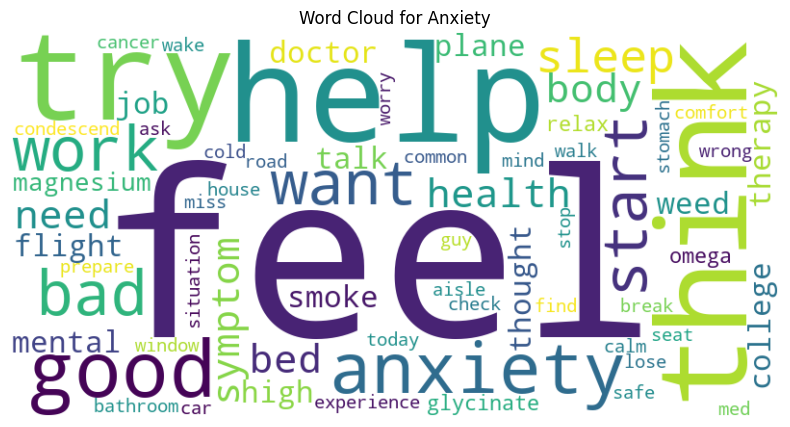

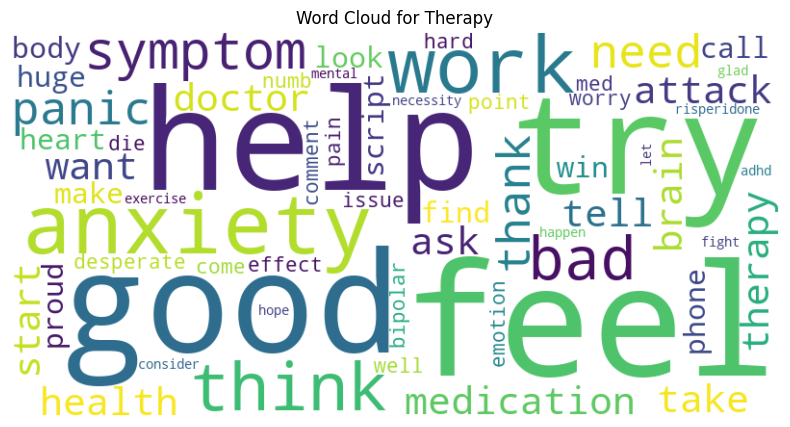

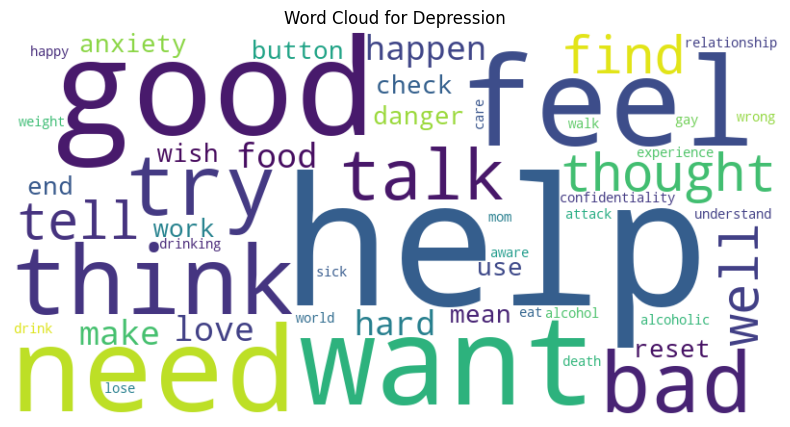

In [70]:

# Word Clouds per topic
for topic in df_keywords["Topic"].unique():
  words = df_keywords[df_keywords["Topic"] == topic]["Keyword"]
  wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Word Cloud for {topic}")
  plt.show()